<a href="https://colab.research.google.com/github/RobertoVargasJabre/ML/blob/master/Tarea1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <center> EFEB8001 - Machine Learning<br /> Tarea 1: Perceptron multicapa</center> </h1>
<h2> <center>Profesor: Jorge Vergara </center></h2>
<h3><center>2° semestre 2019 - UTEM </center></h3>

 ***

# Inicialización de parámetros

In [4]:
%tensorflow_version 1.x

1.15.2


In [0]:
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pylab as plt
from os.path import sep
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Dígito a identificar. Fija el dígito verificador de tu RUT (K=0).
RUT_veri_number = 4

# Parámetros de entrenamiento
minibatch_size = 32
max_epochs = 100
max_validation_checks = 25

# Parámetros de gradiente descendente estocástico
learning_rate = 0.1

# Función de pérdida: 'cross_entropy' or 'mse'
loss_function_name = 'cross_entropy'  

# Parámetros de configuración de la red
n_inputs = 28*28    # Número de entradas
n_hidden = 25       # Número de neuronas en la capa oculta
n_classes = 2       # Número de salidas de la red
n_neurons = (n_inputs, n_hidden, n_classes)
# n_neurons = (n_inputs,  n_classes)   # Descomente para eliminar capa oculta

# log dir
experiment_name = "default"
folder_repet   = "1"         # Cambiar valor cuando realice repeticiones de los experimentos
logdir = "tarea_1_logs" + sep + experiment_name + sep + folder_repet

# Preparación de base de datos MNIST


In [0]:
def process_dataset(images, labels, selected_class):
    shuffled_indexes = np.random.permutation(len(labels))
    images = images[shuffled_indexes]
    labels = labels[shuffled_indexes]
    selected_column = labels[:, selected_class]
    selected_images_indexes = np.where(selected_column == 1)[0]
    selected_size = len(selected_images_indexes)
    non_selected_indexes_subset = np.where(selected_column == 0)[0][:selected_size]
    indexes = np.concatenate((selected_images_indexes, non_selected_indexes_subset), axis=0)
    np.random.shuffle(indexes)
    images_subset = images[indexes]
    labels_subset = selected_column[indexes]
    return images_subset, labels_subset

# Carga base de datos. Datos originales se guardan en carpeta data
mnist = input_data.read_data_sets("data"+sep, one_hot=True)

# Crea base de datos. Separa datos de dígito buscado versus el resto. 
# El análisis se hace para train, valid y test 
training_images,   training_labels   = process_dataset(mnist.train.images,      mnist.train.labels,      RUT_veri_number)
validation_images, validation_labels = process_dataset(mnist.validation.images, mnist.validation.labels, RUT_veri_number)
testing_images,  testing_labels      = process_dataset(mnist.test.images,       mnist.test.labels,       RUT_veri_number)

# Visualizar algunas imagenes del dataset
# Si no desea visualizar cambiar if True por if False
if True:
    nrows, ncols = 3,2
    idxs_im = np.c_[np.where(training_labels==True)[0], np.where(training_labels==False)[0]]
    idxs_ax = np.asarray(np.unravel_index(np.arange(nrows*ncols), (nrows, ncols))).T
    fig,axs=plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
    for count in range(nrows*ncols):
        if count%2 == 0: image = training_images[idxs_im[count,0]]
        else:            image = training_images[idxs_im[count,1]]
        axs[idxs_ax[count,0],idxs_ax[count,1]].imshow(image.reshape((28, 28)))
    fig.suptitle('Positive Class        -        Negative Class',fontsize=16)
    _ = np.vectorize(lambda ax:ax.axis('off'))(axs)

# Construcción de MLP

In [0]:
# Se crea entrada de la red
MLP_input = tf.placeholder(tf.float32, shape=[None, n_inputs], name='MLP_input_placeholder')
previous_layer = MLP_input

# Pointer to weights and biases for regularization
regularizers = 0

# Iteration constructing one layer at a time
for level in range(len(n_neurons)-1):
    with tf.variable_scope("layer_"+str(level)):
        weights = tf.get_variable("weights_"+str(level), [n_neurons[level],n_neurons[level+1]], initializer=tf.contrib.layers.xavier_initializer())
        #weights = tf.Variable(tf.truncated_normal([n_neurons[level],n_neurons[level+1]], stddev=0.1))
        biases = tf.get_variable("biases_"+str(level), [n_neurons[level+1]], initializer=tf.constant_initializer(0.0))
        applied_weights = tf.matmul(previous_layer, weights) + biases

        regularizers += tf.nn.l2_loss(weights)

        if level < len(n_neurons)-2:
            layer = tf.nn.sigmoid(applied_weights)
            previous_layer = layer
        else:
            MLP = applied_weights
            break

out_softmax = tf.nn.softmax(MLP)

# Función de costo

In [0]:
# Accomodate target
target = tf.placeholder(tf.float32, shape=None, name='target_placeholder')
one_hot_target = tf.one_hot(tf.cast(target, dtype=tf.int32), 2)


with tf.variable_scope("loss_function"):
    if loss_function_name == 'cross_entropy':
        # Cross Entropy
        loss_function = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=MLP,
                labels=one_hot_target,
                name='loss')
        )
    elif loss_function_name == 'mse':
        # Mean Squared Error
        loss_function = tf.reduce_mean(tf.square(one_hot_target - tf.nn.softmax(logits=MLP)))
    else:
        raise ValueError('Wrong value for loss_function_name')

with tf.variable_scope("accuracy"):    
    correct_predictions = tf.equal(tf.argmax(MLP, 1),
                                   tf.argmax(one_hot_target, 1))
    accuracy = tf.reduce_mean(
                tf.cast(correct_predictions, tf.float32), name='accuracy')

# -- Punteros para guardar datos y visualizar en tensorboard ----
# Tensorboard summary
acc_sum = tf.summary.scalar("accuracy", accuracy)
# loss function summary
loss_summ = tf.summary.scalar("loss_function", loss_function)
# add all summaries to summ
summ = tf.summary.merge_all()
val_summ = tf.summary.merge([acc_sum, loss_summ])

# Regularización 

In [0]:
# loss_function += 0.0005 * regularizers

# Método de optimización

In [0]:
with tf.variable_scope("train_process"):
    # Gradient Descent with Momentum
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # Adam Algorithm
    # optimizer = tf.train.AdamOptimizer()

    training_algorithm = optimizer.minimize(loss_function)

# Entrenamiento del método

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer1 = tf.summary.FileWriter(logdir + sep + "train")
writer2 = tf.summary.FileWriter(logdir + sep + "validation")
writer1.add_graph(sess.graph)

n_minibatches = int(np.shape(training_images)[0] / minibatch_size) 

prev_validation_loss = 100.0
validation_checks = 0
validation_period = 10

TRAIN_STOP_FLAG = False
results_train = []
results_valid = []
results_test  = []
for epoch in tqdm(range(max_epochs)):
    if TRAIN_STOP_FLAG:
        break
    new_indexes = np.random.permutation(len(training_labels))
    training_images[new_indexes]
    training_labels[new_indexes]
    for i_mb in range(n_minibatches):
        if TRAIN_STOP_FLAG:
            break
        a,b = i_mb*minibatch_size, (i_mb+1)*minibatch_size
        iteration = epoch*n_minibatches+i_mb
        images_minibatch = training_images[a:b]
        labels_minibatch = training_labels[a:b]
        
        sess.run(training_algorithm,feed_dict={MLP_input: images_minibatch, target: labels_minibatch})
        if iteration % validation_period == 0:
            loss_valid, validation_acc, s = sess.run(
                [loss_function, accuracy, summ],
                feed_dict={MLP_input: validation_images, target: validation_labels})
            
            writer2.add_summary(s, iteration)
        
            loss_train, train_acc, s = sess.run([loss_function, accuracy, summ],
                                     feed_dict={MLP_input: training_images, target: training_labels})
            writer1.add_summary(s, iteration)
            
            loss_test, test_acc = sess.run([loss_function, accuracy],
                                     feed_dict={MLP_input: testing_images, target: testing_labels})
            
            results_train += [np.asarray([epoch,a,b,iteration,loss_valid, validation_acc])]
            results_valid += [[epoch, a, b, iteration, loss_train, train_acc]]
            results_test  += [[epoch, a, b, iteration, loss_test,  test_acc]]
        
            if loss_valid > prev_validation_loss:
                validation_checks += 1
            else:
                validation_checks = 0
                prev_validation_loss = loss_valid
                
#             print("Epoch: %d/%d, iter: %d. " % (
#                 epoch+1, 
#                 max_epochs,
#                 iteration), end='')
#             print("Loss (train/val): %.3f / %.3f. Val. accuracy: %.1f%%, Val. checks: %d/%d" %(
#                       loss_train,
#                       loss_valid,
#                       validation_acc*100, 
#                       validation_checks, 
#                       max_validation_checks))
            
            if validation_checks >= max_validation_checks:
                TRAIN_STOP_FLAG = True

if TRAIN_STOP_FLAG:
    print('======================= Early stopping. Fin entrenamiento ===================')
    
writer1.flush()
writer2.flush()

# ---------- Matrices de resultados para train, valid y test ----------
# Formato [epoca, inicio_batch, fin_batch, iteraciones, loss, accuracy]
res_train = np.vstack(results_train)
res_valid = np.vstack(results_valid)
res_test  = np.vstack(results_test)

# ------- Salidas de la red para train, valid y test ----------
# Recuerde que red tiene solo una salida, pero acá solo se utiliza una para calcular las curvas ROC y DET
predicted_training_labels   = sess.run(out_softmax[:,1], feed_dict={MLP_input: training_images})
predicted_validation_labels = sess.run(out_softmax[:,1], feed_dict={MLP_input: validation_images})
predicted_test_labels       = sess.run(out_softmax[:,1], feed_dict={MLP_input: testing_images})

# ------ Guarda resultados en formato numpy en archivo results.npy --------
np.save(logdir + sep + 'results.npy',[res_train,
                                      res_valid,
                                      res_test,
                                      predicted_training_labels,
                                      predicted_validation_labels,
                                      predicted_test_labels])

  5%|▌         | 5/100 [00:04<01:29,  1.07it/s]

======================= Early stopping. Fin entrenamiento ===================


In [0]:
# Si se desea recuperar los datos guardados en results.npy descomentar las siguientes lineas

# temp = np.load(logdir + sep + 'results.npy', allow_pickle=True)
# res_train = temp[0]
# res_valid = temp[1]
# res_test  = temp[2]
# predicted_training_labels   = temp[3]
# predicted_validation_labels = temp[4]
# predicted_test_labels       = temp[5]

# Visualización del desempeño de la red

Text(0.5, 0, 'Epochs')

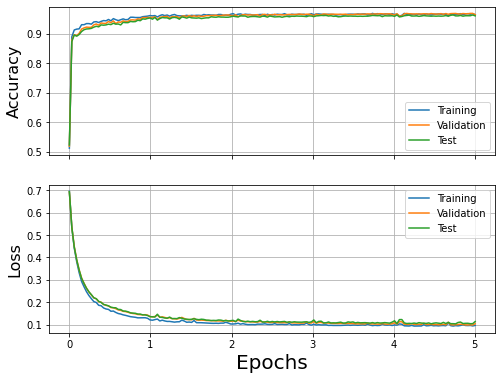

In [10]:
fig2,axs2 = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
epochs_vec = res_train[:,3]/(len(training_labels)/minibatch_size)
axs2[0].plot(epochs_vec, res_train[:,-1], label='Training')
axs2[0].plot(epochs_vec, res_valid[:,-1], label='Validation')
axs2[0].plot(epochs_vec, res_test[:,-1], label='Test')
axs2[0].set_ylabel('Accuracy',fontsize=16)
axs2[0].legend()
axs2[0].grid(True)
axs2[1].plot(epochs_vec, res_train[:,4], label='Training')
axs2[1].plot(epochs_vec, res_valid[:,4], label='Validation')
axs2[1].plot(epochs_vec, res_test[:,4], label='Test')
axs2[1].set_ylabel('Loss',fontsize=16)
axs2[1].legend()
axs2[1].grid(True)
axs2[1].set_xlabel('Epochs',fontsize=20)

## Graficar resultados
### Códigos para graficar

In [0]:

# Código para graficar matriz de confusion
# get from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          ax=None,#plt.subplots()[1],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

## La matriz de confusion se obtiene de sklearn, pero acá esta el código para estudiar
# def confusion_matrix(targets, outputs):
#     '''Returns a confusion matrix. Both targets and outputs
#     should be 1-D arrays of zeros and ones.'''
#     encoded_data = 2*targets+outputs  # Map targets and outputs to {0, 1, 2, 3}
#     TN = np.sum(encoded_data == 0)  # True negatives
#     FP = np.sum(encoded_data == 1)  # False positives
#     FN = np.sum(encoded_data == 2)  # False negatives
#     TP = np.sum(encoded_data == 3)  # True positives
#     return ((TP, FP), (FN, TN))

def roc_curve(targets, outputs):
    '''Returns a ROC curve. Outputs should be in range 0-1
    in order to move the threshold.'''
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        outputs_with_threshold = (outputs > threshold).astype(np.float)
        ((TP, FP), (FN, TN)) = confusion_matrix(
            targets, 
            outputs_with_threshold)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)

In [0]:
th = 0.5 # Umbral para determinar matriz de confusión
temp='%s -- Clasificaciones correctas:%.2f%%\nPrecision: %.2f%% -- Recall: %.2f%%'

### Gráficos de base de entrenamiento

Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5, 0.98, 'Training -- Clasificaciones correctas:96.38%\nPrecision: 95.06% -- Recall: 97.85%')

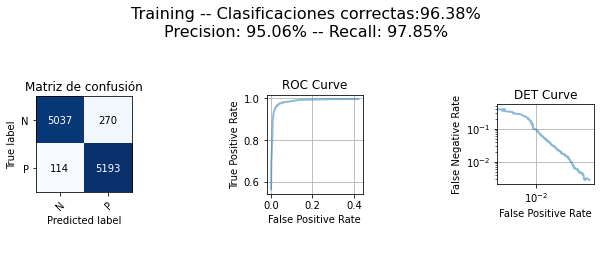

In [14]:
nameDataset = 'Training'
y_true = training_labels
y_pred = predicted_training_labels

[[VN,FP],[FN,VP]] = confusion_matrix(y_true.astype(np.bool),
                                     (y_pred>th).astype(np.bool))
fig3,axs3 = plt.subplots(nrows=1, ncols=5, figsize=(10,4))
plot_confusion_matrix(y_true.astype(np.int),
                      (y_pred>th).astype(np.int),
                      np.asarray(['N','P']),
                      ax=axs3[0], 
                      title='Matriz de confusión')

tpr, fpr = roc_curve(y_true, y_pred)

axs3[1].axis('off')
axs3[3].axis('off')

axs3[2].plot(fpr, tpr, linewidth=2, alpha=0.5)
axs3[2].set_xlabel("False Positive Rate")
axs3[2].set_ylabel("True Positive Rate")
axs3[2].grid()
axs3[2].set_aspect('equal', 'box')
axs3[2].set_title('ROC Curve')

axs3[4].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
axs3[4].set_xlabel("False Positive Rate")
axs3[4].set_ylabel("False Negative Rate")
axs3[4].set_yscale('log')
axs3[4].set_xscale('log')
axs3[4].set_aspect('equal', 'box')
axs3[4].grid()
axs3[4].set_title('DET Curve');

fig3.suptitle(temp% (nameDataset, 100.0*(VP+VN)/(VP+VN+FP+FN), 100.0*VP/(VP+FP), 100.0*VP/(VP+FN)),fontsize=16)

### Gráficos de base de validación

Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5, 0.98, 'Validation -- Clasificaciones correctas:96.36%\nPrecision: 95.59% -- Recall: 97.20%')

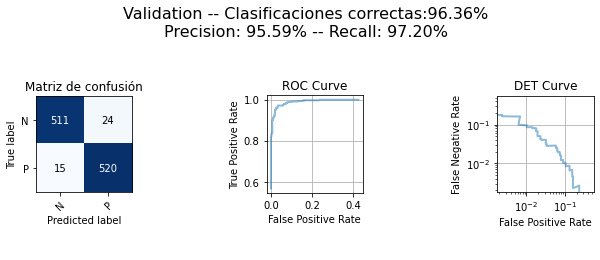

In [15]:
nameDataset = 'Validation'
y_true = validation_labels
y_pred = predicted_validation_labels

[[VN,FP],[FN,VP]] = confusion_matrix(y_true.astype(np.bool),
                                     (y_pred>th).astype(np.bool))
fig3,axs3 = plt.subplots(nrows=1, ncols=5, figsize=(10,4))
plot_confusion_matrix(y_true.astype(np.int),
                      (y_pred>th).astype(np.int),
                      np.asarray(['N','P']),
                      ax=axs3[0], 
                      title='Matriz de confusión')

tpr, fpr = roc_curve(y_true, y_pred)

axs3[1].axis('off')
axs3[3].axis('off')

axs3[2].plot(fpr, tpr, linewidth=2, alpha=0.5)
axs3[2].set_xlabel("False Positive Rate")
axs3[2].set_ylabel("True Positive Rate")
axs3[2].grid()
axs3[2].set_aspect('equal', 'box')
axs3[2].set_title('ROC Curve')

axs3[4].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
axs3[4].set_xlabel("False Positive Rate")
axs3[4].set_ylabel("False Negative Rate")
axs3[4].set_yscale('log')
axs3[4].set_xscale('log')
axs3[4].set_aspect('equal', 'box')
axs3[4].grid()
axs3[4].set_title('DET Curve');

fig3.suptitle(temp% (nameDataset, 100.0*(VP+VN)/(VP+VN+FP+FN), 100.0*VP/(VP+FP), 100.0*VP/(VP+FN)),fontsize=16)

### Gráficos de base de Test

Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5, 0.98, 'Test -- Clasificaciones correctas:95.98%\nPrecision: 93.79% -- Recall: 98.47%')

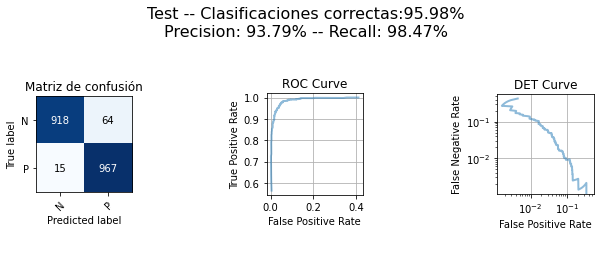

In [16]:
nameDataset = 'Test'
y_true = testing_labels
y_pred = predicted_test_labels

[[VN,FP],[FN,VP]] = confusion_matrix(y_true.astype(np.bool),
                                     (y_pred>th).astype(np.bool))
fig3,axs3 = plt.subplots(nrows=1, ncols=5, figsize=(10,4))
plot_confusion_matrix(y_true.astype(np.int),
                      (y_pred>th).astype(np.int),
                      np.asarray(['N','P']),
                      ax=axs3[0], 
                      title='Matriz de confusión')

tpr, fpr = roc_curve(y_true, y_pred)

axs3[1].axis('off')
axs3[3].axis('off')

axs3[2].plot(fpr, tpr, linewidth=2, alpha=0.5)
axs3[2].set_xlabel("False Positive Rate")
axs3[2].set_ylabel("True Positive Rate")
axs3[2].grid()
axs3[2].set_aspect('equal', 'box')
axs3[2].set_title('ROC Curve')

axs3[4].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
axs3[4].set_xlabel("False Positive Rate")
axs3[4].set_ylabel("False Negative Rate")
axs3[4].set_yscale('log')
axs3[4].set_xscale('log')
axs3[4].set_aspect('equal', 'box')
axs3[4].grid()
axs3[4].set_title('DET Curve');

fig3.suptitle(temp% (nameDataset, 100.0*(VP+VN)/(VP+VN+FP+FN), 100.0*VP/(VP+FP), 100.0*VP/(VP+FN)),fontsize=16)